# Text Mining


In [1]:
import multiprocessing

import nltk
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Loading and Preprocessing

In [2]:
import matplotlib.pyplot as plt

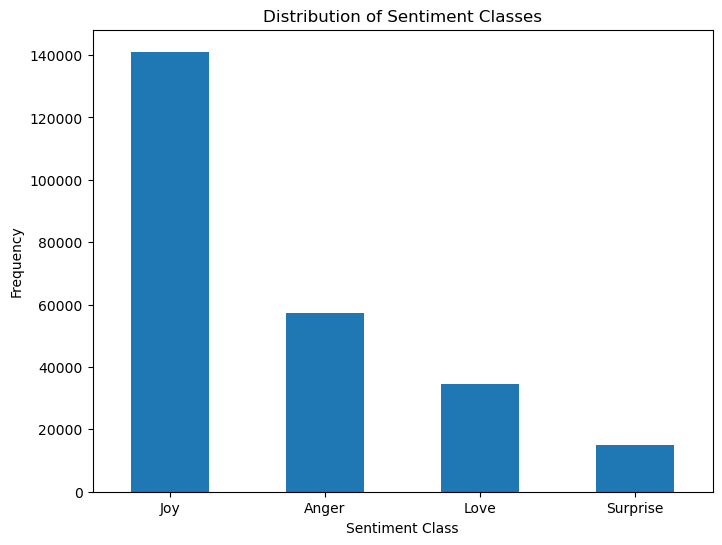

In [3]:
# Loading the data
df = pd.read_csv("text_mining/emotions.csv")

# Plotting a histogram
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar')

plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

In [4]:
# Funtion for undersampling
def undersample_data(data, label_column, columns):
    # Find the smallest class size
    min_class_size = data[label_column].value_counts().min()
    
    # Group by the label and take the first `min_class_size` samples from each group
    balanced_data = data.groupby(label_column)[columns].apply(lambda x: x.head(min_class_size), include_groups=False).reset_index(drop=True)
    return balanced_data


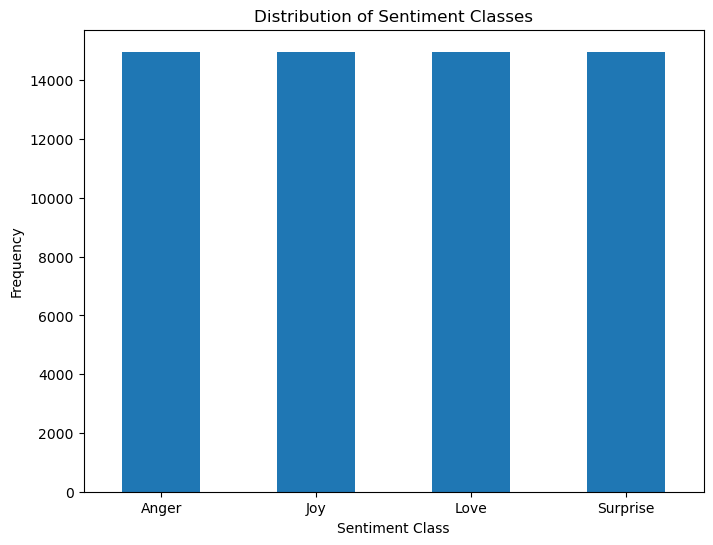

In [5]:
# Apply the undersampling 
columns = list(df)
balanced_data = undersample_data(df, 'label', columns)

# Plotting a histogram
plt.figure(figsize=(8, 6))
balanced_data['label'].value_counts().plot(kind='bar')

plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


In [6]:
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_document(document):                 
    
    tokens = word_tokenize(document)
    
    # lowercase, remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    
    return " ".join(processed_tokens)
    

In [7]:
corpus = balanced_data['text']

# number of tokens before preprocessing
tokens_before = sum(len(word_tokenize(doc)) for doc in corpus)

# preprocessing the corpus
preprocess_corpus = [preprocess_document(doc) for doc in corpus]

# number of tokens after preprocessing
tokens_after = sum(len(doc.split()) for doc in preprocess_corpus)

print(f"Total tokens before preprocessing: {tokens_before}")
print(f"Total tokens after preprocessing: {tokens_after}")

Total tokens before preprocessing: 1188318
Total tokens after preprocessing: 575823


In [8]:
labels = balanced_data['label']
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.2, random_state=12345, stratify=labels)

In [9]:
corpus_test

32491    i feel blessed each day with what i have been ...
41565    i feel like a loser because all the guys i hav...
24389           i had a funny feeling when i accepted them
14390    i feel greedy about wanting to see this film s...
50854    i am extremely happy with is my work in the cr...
                               ...                        
13952    ive actually tried to cultivate it as in i onl...
31991    i feel like i am more loyal to her than i am t...
20611        i feel like i should be happy but im just not
48377    i just feel kinda shocked and sad to be all al...
16536    i make sure to stop and meditate on the truths...
Name: text, Length: 11978, dtype: object

In [10]:
corpus_train

16078                          my parents came to visit me
1834     ill state that i am angry at myself for feelin...
17378      i feel calm complete and whole after i meditate
40050                         i was starting to feel horny
48768    i can see my office and feel somewhat amazed a...
                               ...                        
41880    i was feeling generous hehe she doesnt need my...
39995    i did those feelings of needing to be accepted...
11816    i feel impatient desparate sad or lonely i rea...
3221     i am learning to take inventory of my feelings...
12235    i suppose in some ways i should feel irritated...
Name: text, Length: 47910, dtype: object

## Bag-of-Words

In [11]:
# Preprocessing the train and the test splits of the corpus 
corpus_train = corpus_train.apply(preprocess_document)
corpus_test = corpus_test.apply(preprocess_document)

# Creating Bag-of-Words model
bow = CountVectorizer()
x_train = bow.fit_transform(corpus_train)
x_test = bow.transform(corpus_test)

# Train SGD Classifier
sgd_clf = SGDClassifier(loss='log_loss', random_state=12345)
sgd_clf.fit(x_train, y_train)

train_predictions = sgd_clf.predict(x_train)
test_predictions = sgd_clf.predict(x_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")


Training Accuracy: 0.967
Test Accuracy: 0.953


## N-Grams

In [12]:
def preprocess_mle(document):
    return [token.lower() for token in word_tokenize(document)]

corpus_mle = balanced_data['text'].apply(preprocess_mle)
corpus_mle_labels = balanced_data['label']
train_mle, test_mle, train_labels_mle, test_labels_mle = train_test_split(corpus_mle, corpus_mle_labels, test_size=0.2, random_state=12345, stratify=corpus_mle_labels)

def train_mle_model(train_corpus, n):
    ngram_tuples, vocab = padded_everygram_pipeline(n, train_corpus)
    model = MLE(n)
    model.fit(ngram_tuples, vocab)
    return model

In [13]:
mle_2gram = train_mle_model(train_mle, 2)
mle_5gram = train_mle_model(train_mle, 5)

In [14]:
def generate_document(mle_model, max_words=50):
    text = []
    context = []
    for i in range(max_words):
        next_word = mle_model.generate(text_seed=context)
        if next_word == '</s>':
            break
        text.append(next_word)
        context = (context + [next_word])[-(mle_model.order - 1):]
    return " ".join(text)

In [15]:
# Training Bag-of-Words classifier
bow = CountVectorizer()
corpus_train = [" ".join(doc) for doc in train_mle]
x_train = bow.fit_transform(corpus_train)
sgd_clf = SGDClassifier(loss='log_loss', random_state=12345)
sgd_clf.fit(x_train, train_labels_mle)

SGDClassifier(loss='log_loss', random_state=12345)

In [16]:
def classify_document(document):
    doc = bow.transform([document])
    return sgd_clf.predict(doc)[0]

In [17]:
doc_2gram = generate_document(mle_2gram)
doc_5gram = generate_document(mle_5gram)

In [18]:
print("Generated Document (2-gram):", doc_2gram)
print("Classification (2-gram):", classify_document(doc_2gram))

print("\nGenerated Document (5-gram):", doc_5gram)
print("Classification (5-gram):", classify_document(doc_5gram))

Generated Document (2-gram): was trying to choose to recognize what i have a few times now
Classification (2-gram): Joy

Generated Document (5-gram): 
Classification (5-gram): Joy


In [19]:
def generate_and_classify_documents(mle_model, num_docs=1000):
    classifications = []
    for i in range(num_docs):
        doc = generate_document(mle_model)
        classifications.append(classify_document(doc))
    return classifications

classifications_2gram = generate_and_classify_documents(mle_2gram)
classifications_5gram = generate_and_classify_documents(mle_5gram)

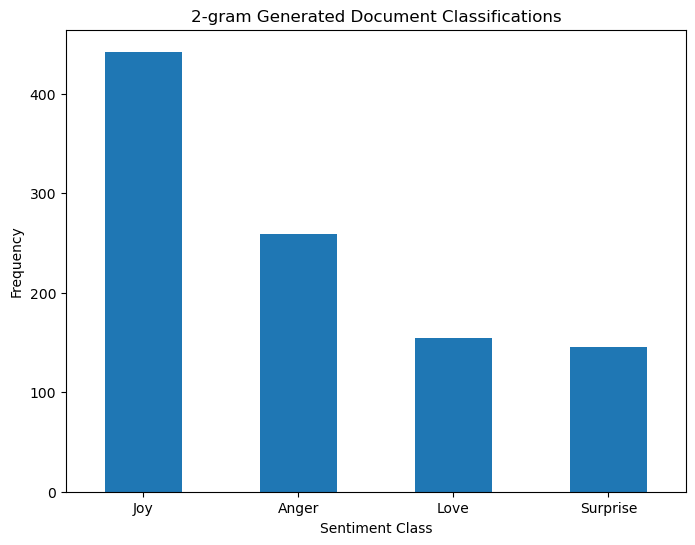

In [20]:
plt.figure(figsize=(8, 6))

pd.Series(classifications_2gram).value_counts().plot(kind='bar')
plt.title("2-gram Generated Document Classifications")
plt.xlabel("Sentiment Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

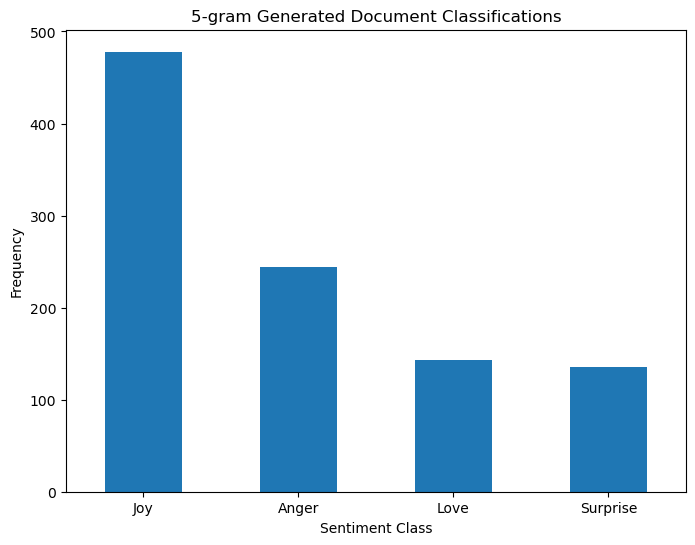

In [21]:
plt.figure(figsize=(8, 6))

pd.Series(classifications_5gram).value_counts().plot(kind='bar')
plt.title("5-gram Generated Document Classifications")
plt.xlabel("Sentiment Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

## Word2Vec

In [22]:
corpus_word2vec = corpus_mle.tolist()
word2vec_model = Word2Vec(
    sentences=corpus_word2vec,
    vector_size=25,
    window=5,
    min_count=3,
    sg=1,
    epochs=50,
    workers=4
)

In [23]:
target = "christmas"
print(f"Word2Vec embedding for '{target}':")
print(word2vec_model.wv[target])

Word2Vec embedding for 'christmas':
[ 0.276874    0.00644255  0.57469046 -0.73151314  0.89638144  0.6890457
  0.29865322  1.0221087   0.10204154 -0.428865    0.3475411   0.11099391
  0.18577196 -0.39826798 -0.40913093  0.5917831   0.34280467  0.5245489
 -0.71778405 -0.00455266  0.35580772  0.19753228 -0.39551574 -0.07814541
  0.6331042 ]


In [24]:
most_similar_words = word2vec_model.wv.most_similar(target, topn=3)

# Get top 3 most dissimilar words
most_dissimilar_words = word2vec_model.wv.most_similar(negative=[target], topn=3)

# Print most similar words
print("Top 3 most similar words to 'christmas':")
for word, similarity in most_similar_words:
    print(f"{word}: {round(similarity, 3)}")

print("\nTop 3 most dissimilar words to 'christmas':")
for word, similarity in most_dissimilar_words:
    print(f"{word}: -{round(similarity, 3)}")

Top 3 most similar words to 'christmas':
holiday: 0.871
halloween: 0.808
carols: 0.808

Top 3 most dissimilar words to 'christmas':
manner: -0.258
automatic: -0.246
islam: -0.234


In [25]:
# Find Christmas-related emotions
related_emotions = word2vec_model.wv.most_similar(positive=["christmas", "emotion"], topn=3)

# Find Christmas-unrelated emotions
unrelated_emotions = word2vec_model.wv.most_similar(positive=["emotion"], negative=["christmas"], topn=3)

# Print results
print("Top 3 Christmas-Related Emotions:")
for word, similarity in related_emotions:
    print(f"{word}: {round(similarity, 3)}")

print("\nTop 3 Christmas-Unrelated Emotions:")
for word, similarity in unrelated_emotions:
    print(f"{word}: {round(similarity, 3)}")

Top 3 Christmas-Related Emotions:
excitement: 0.842
thankfulness: 0.811
enormity: 0.791

Top 3 Christmas-Unrelated Emotions:
reaction: 0.687
annoyance: 0.661
expression: 0.652
